In [55]:
# general imports
from os import path
import csv
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.misc import toimage
import tensorflow as tf

In [42]:
# check if gpu is availalbe
from tensorflow.python.client import device_lib
for x in device_lib.list_local_devices():
    print(x.name)

/cpu:0
/gpu:0


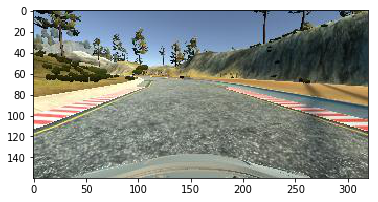

In [56]:
# show a frame 
img = cv2.imread(glob.glob('data3/IMG/center_*')[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(toimage(np.array(img, dtype=np.float32)))
plt.show()

In [57]:
# load data for X and y
with open('data3/driving_log.csv') as f_csv:
    telemetry = [l for l in csv.reader(f_csv)]

# drop csv headers that may exist
telemetry = np.array(telemetry[1:])
    
center_im_idx =      0
left_im_idx =        1
right_im_idx =       2
steering_angle_idx = 3

def read_image_rgb(impath):
    _, filename = path.split(impath)
    tmp = cv2.imread('data3/IMG/{}'.format(filename))
    tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)
    tmp = cv2.resize(tmp, (32,32))
    return np.array(tmp)

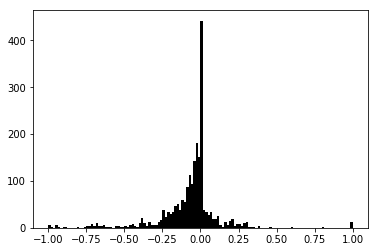

In [58]:
# plot a distribution of steering angles
y_all = telemetry[:,steering_angle_idx].astype(np.float32)
plt.hist(y_all, bins=128, color=(0,0,0))
plt.show()

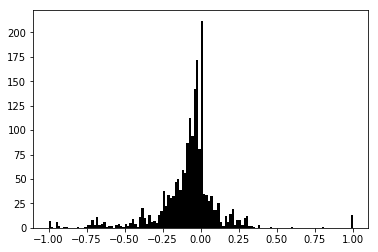

In [46]:
# prune data - remove % of images with steering angle within +/-epsilon
def prune(dataset, perc_drop=.5, max_epsilon=.05):
    def in_epsilon(s):
        return abs(float(s[steering_angle_idx])) < max_epsilon
    dataset = shuffle(dataset)
    mask = []
    nb_max = sum(in_epsilon(x) for x in dataset) * perc_drop
    nb_c = 0
    for s in dataset:
        if nb_c <= nb_max and in_epsilon(s):
            nb_c += 1
            mask.append(False)
        else:
            mask.append(True)
    mask = np.array(mask, dtype=bool)
    return dataset[mask]

p2_telemetry = prune(telemetry, perc_drop=.5, max_epsilon=.02)
# p2_telemetry = prune(p1_telemetry, perc_drop=.1, max_epsilon=0.1) that was not needed

# plot a distribution
y_pruned = p2_telemetry[:,steering_angle_idx].astype(np.float32)
plt.hist(y_pruned, bins=128, color=(0,0,0))
plt.show()

In [47]:
# dataset split
train_samples, validation_samples = train_test_split(p2_telemetry, test_size=0.2)

In [48]:
# define preprocessing and augmentation to be used by generator as functions
nb_augmentations = 4

def flip(img):
    return cv2.flip(img, 1)

# one real image yields itself, shift_r, shift_l, flip
# so ultimately 4 images are appended to dest_x and dest_y lists
def append_augmented(sample, dest_x, dest_y):
    im_orig = read_image_rgb(sample[center_im_idx])
    im_left = read_image_rgb(sample[left_im_idx])
    im_right = read_image_rgb(sample[right_im_idx])
    angle = float(sample[steering_angle_idx])
    # flip
    dest_x.append(flip(im_orig))
    dest_y.append(-angle)
    # left
    dest_x.append(im_left)
    dest_y.append(angle + .2)
    # right
    dest_x.append(im_right)
    dest_y.append(angle - .2)
    # center
    dest_x.append(im_orig)
    dest_y.append(angle)

In [49]:
# define a generator for Keras
# if augment is set to True, generator will yield more samples!
def generator(samples, batch_size=32, augment=False):
    nb_samples = len(samples)
    while 1:
        samples = shuffle(samples)
        for offset in range(0, nb_samples, batch_size):
            batch = samples[offset:offset+batch_size]
            batch_x_tmp = []
            batch_y_tmp = []
            for sample in batch:
                if augment:
                    append_augmented(
                        sample,
                        batch_x_tmp,
                        batch_y_tmp,
                    )
                else:
                    batch_x_tmp.append(read_image_rgb(sample[center_im_idx]))
                    batch_y_tmp.append(sample[steering_angle_idx])
            yield (np.array(batch_x_tmp, dtype=np.float32), np.array(batch_y_tmp, dtype=np.float32))

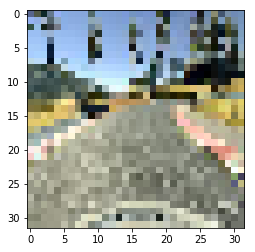

steering 0.094308


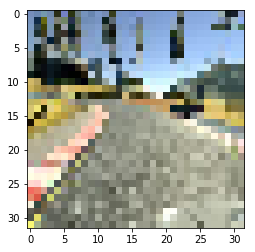

steering 0.105692


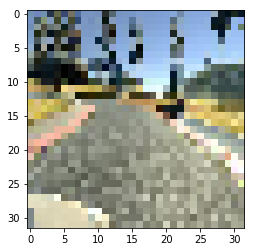

steering -0.294308


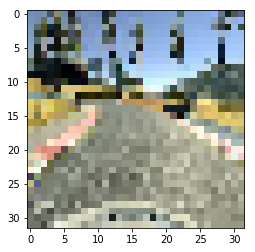

steering -0.094308


In [59]:
# test generator and preprocessing
test_gen_data = train_samples[890:891]
test_gen = generator(test_gen_data, batch_size=1, augment=True)

x_data, y_data = next(test_gen)
for (x, y) in zip(x_data, y_data):
    plt.imshow(toimage(x))
    plt.show()
    print('steering', y)

Epoch 1/5
5860/5860 [==============================] - 5s - loss: 0.0928 - val_loss: 0.0275

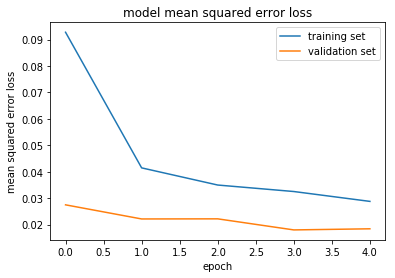

In [53]:
# train the model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, Dropout, Activation
from keras.layers.convolutional import Cropping2D, Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

model = Sequential()
model.add(Cropping2D(cropping=((10,4), (0,0)), input_shape=(32,32,3)))
model.add(Lambda(lambda x: x / 127.5 - 1))
model.add(Conv2D(32, 3, 3, activation='elu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.5))
model.add(Conv2D(32, 3, 3, activation='elu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.5))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('elu'))
model.add(Dense(16))
model.add(Activation('elu'))
model.add(Dense(1))

train_generator = generator(train_samples, batch_size=32, augment=True)
validation_generator = generator(validation_samples, batch_size=32)

model.compile(optimizer='adam', loss='mse')
ts_len = len(train_samples) * nb_augmentations
history_object = model.fit_generator(train_generator,
                                     samples_per_epoch=ts_len,
                                     nb_val_samples=len(validation_samples),
                                     nb_epoch=5,
                                     validation_data=validation_generator)
model.save('model/model.h5')

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()